## 特征对生成

In [1]:
import pandas as pd

In [2]:
mirbase = pd.read_csv('../../data/miRbase/hsa.gff3.txt',comment='#',sep='\t',engine='python',header=None)
mirbase.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,chr1,.,miRNA_primary_transcript,17369,17436,.,-,.,ID=MI0022705,Alias=MI0022705,Name=hsa-mir-6859-1,NaN
1,chr1,.,miRNA,17409,17431,.,-,.,ID=MIMAT0027618,Alias=MIMAT0027618,Name=hsa-miR-6859-5p,Derives_from=MI0022705
2,chr1,.,miRNA,17369,17391,.,-,.,ID=MIMAT0027619,Alias=MIMAT0027619,Name=hsa-miR-6859-3p,Derives_from=MI0022705
3,chr1,.,miRNA_primary_transcript,30366,30503,.,+,.,ID=MI0006363,Alias=MI0006363,Name=hsa-mir-1302-2,NaN
4,chr1,.,miRNA,30438,30458,.,+,.,ID=MIMAT0005890,Alias=MIMAT0005890,Name=hsa-miR-1302,Derives_from=MI0006363


In [3]:
mirbase_columns = ['chromosome','_1','type','start','end','_2','strand','_3','ID','Alias','Name','From']
mirbase.columns = mirbase_columns
mirbase['Name'] = mirbase['Name'].str.replace('Name=','')

miRbase 数据生成 pre_mir 对应 mature_miR

In [4]:
mirbase.loc[mirbase['From'].isnull(),'pre_miR'] = mirbase.loc[mirbase['From'].isnull(),'Name']
mirbase['pre_miR'].fillna(method='ffill',inplace=True)
mirbase.loc[~(mirbase['From'].isnull()),'mature_miR'] = mirbase.loc[~(mirbase['From'].isnull()),'Name']

mirbase.head()

,chromosome,_1,type,start,end,_2,strand,_3,ID,Alias,Name,From,pre_miR,mature_miR
0,chr1,.,miRNA_primary_transcript,17369,17436,.,-,.,ID=MI0022705,Alias=MI0022705,hsa-mir-6859-1,NaN,hsa-mir-6859-1,NaN
1,chr1,.,miRNA,17409,17431,.,-,.,ID=MIMAT0027618,Alias=MIMAT0027618,hsa-miR-6859-5p,Derives_from=MI0022705,hsa-mir-6859-1,hsa-miR-6859-5p
2,chr1,.,miRNA,17369,17391,.,-,.,ID=MIMAT0027619,Alias=MIMAT0027619,hsa-miR-6859-3p,Derives_from=MI0022705,hsa-mir-6859-1,hsa-miR-6859-3p
3,chr1,.,miRNA_primary_transcript,30366,30503,.,+,.,ID=MI0006363,Alias=MI0006363,hsa-mir-1302-2,NaN,hsa-mir-1302-2,NaN
4,chr1,.,miRNA,30438,30458,.,+,.,ID=MIMAT0005890,Alias=MIMAT0005890,hsa-miR-1302,Derives_from=MI0006363,hsa-mir-1302-2,hsa-miR-1302


In [5]:
miR_pair = mirbase[['pre_miR','mature_miR']].dropna()
print('pre_miR 配对成熟 miRNA',miR_pair.shape)

pre_miR 配对成熟 miRNA (2883, 2)


**miR_interplay**

miRNA interplay, 靶 miRNA 部分对应前体 miRNA，将其对应到每个成熟个体
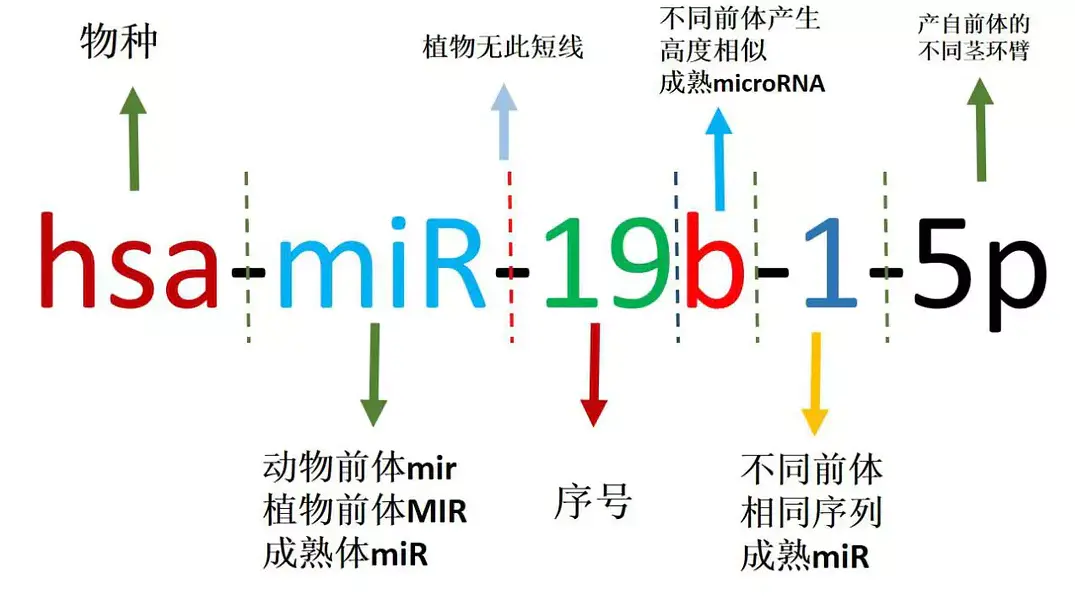

匹配规则：
1. 靶 miRNA 在 miRbase 列表中出现
2. 靶 miRNA 后跟随字母而不是数字

`re.findall((i+'\D+'),j)`：hsa-mir-125 匹配 hsa-miR-125b，而不是 hsa-miR-1258


## 文献报导层面的 miRNA interplay

In [6]:
miR_inter = pd.read_csv('../../result/miR_interplay/miR_interplay_literature.csv',index_col=0)

In [7]:
print(f'miRNA interplay 有 {miR_inter.shape[0]} 条记录')
miR_inter.head()

miRNA interplay 有 60730 条记录


,miRNA,Target Gene,References (PMID),TF name,miRNA name,Action type,SRAID/PMID
0,hsa-miR-20a-5p,HIF1A,18632605,HIF1A,hsa-let-7a,Activation,23426184
1,hsa-miR-20a-5p,HIF1A,18632605,HIF1A,hsa-mir-101,Repression,20478051
2,hsa-miR-20a-5p,HIF1A,18632605,HIF1A,hsa-mir-103,Activation,23426184
3,hsa-miR-20a-5p,HIF1A,18632605,HIF1A,hsa-mir-127,Regulation,22962609
4,hsa-miR-20a-5p,HIF1A,18632605,HIF1A,hsa-mir-1275,Activation,25129238


对应到每个成熟体

In [8]:
mirbase_pre = mirbase.loc[mirbase['type']=='miRNA_primary_transcript','Name'] # mirbase premiR
print('mirbase 中pre_mir 和文献报导的 被调控的 miRNA 交集数',len(set(mirbase_pre)&set(miR_inter['miRNA name'])))
miR_cani = set(mirbase['Name'])&set(miR_inter['miRNA name']) # 候选miRNA

mirbase 中pre_mir 和文献报导的 被调控的 miRNA 交集数 283


**miRNA interplay 数据扩展到成熟miRNA**

In [9]:
miR_pair.loc[miR_pair['pre_miR'].isin(miR_cani)]

,pre_miR,mature_miR
11,hsa-mir-200b,hsa-miR-200b-5p
12,hsa-mir-200b,hsa-miR-200b-3p
14,hsa-mir-200a,hsa-miR-200a-5p
15,hsa-mir-200a,hsa-miR-200a-3p
17,hsa-mir-429,hsa-miR-429
...,...,...
4723,hsa-mir-506,hsa-miR-506-5p
4759,hsa-mir-224,hsa-miR-224-5p
4760,hsa-mir-224,hsa-miR-224-3p
4762,hsa-mir-452,hsa-miR-452-5p


In [10]:
miR_pair_fea = pd.merge(miR_inter,miR_pair,left_on='miRNA name',right_on='pre_miR')
miR_pair_fea['miR_pair_fea'] = miR_pair_fea['miRNA'] + '/'+ miR_pair_fea['mature_miR']
print('miRNA 对维度：',len(set(miR_pair_fea)))

miRNA 对维度： 10


In [11]:
miR_pair_fea.to_csv('../../result/feature_pair/feature_pair.csv',index=None)